In [47]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
import ast
import os
import glob
from pathlib import Path
from scipy.stats import mode
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
     filter_clusters,
)

from functions import(
    ast_df,
    ast_modeling_df,
    is_central_stations,
    binned_log_stats,
)

In [2]:
events_file = '../output/events_reconstruction.csv'
kascade_folder = './KASCADE_Experiment/Ne/'


coordinates_df = pd.read_csv(COORDINATES_PATH)
X_det = np.array(coordinates_df['X'])
Y_det = np.array(coordinates_df['Y'])
Z_det = np.array(coordinates_df['Z'])



kascade1_df = pd.read_csv('../KASCADE_Experiment/Ne/43-47.csv', sep=r',\s*', engine='python')
kascade2_df = pd.read_csv('../KASCADE_Experiment/Ne/47-51.csv', sep=r',\s*', engine='python')
kascade3_df = pd.read_csv('../KASCADE_Experiment/Ne/39-43.csv', sep=r',\s*', engine='python')



events_df = pd.read_csv(events_file)
event_df = ast_df(events_df)
events_df.head(1)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
0,836,6627,63.67,116.71,33.168543,-80.0,5468.278104,1.441416,0.63366,6,6,5,0,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N..."


In [3]:
loss = np.array(events_df['loss'])
X0 = np.array(events_df['X0_opt'])
YO = np.array(events_df['Y0_opt'])
Ne = np.array(events_df['Ne_opt'])
s = np.array(events_df['s_opt'])

In [4]:
n = 2
f_events_df = events_df[events_df.apply(lambda row: is_central_stations(row, n), axis=1)]

In [5]:
f_events_df1 = f_events_df[
    (f_events_df['X0_opt'] > -20) & (f_events_df['X0_opt'] < 20) &
    (f_events_df['Y0_opt'] > -40) & (f_events_df['Y0_opt'] < 40) &
    (f_events_df['loss'] < 1) &
    (f_events_df['s_opt'] < 1.9) & (f_events_df['s_opt'] > 1.2) &
    (f_events_df['Ne_opt'] < 10 ** 5.0) & 
    (f_events_df['Ne_opt'] >  10 ** 4)
    
]

f_events_df2 = f_events_df[
    (f_events_df['X0_opt'] > -20) & (f_events_df['X0_opt'] < 20) &
    (f_events_df['Y0_opt'] > -40) & (f_events_df['Y0_opt'] < 40) &
    (f_events_df['loss'] < 1) &
    (f_events_df['s_opt'] < 1.9) & (f_events_df['s_opt'] > 1.2) &
    (f_events_df['Ne_opt'] < 1e4) &
    (f_events_df['Ne_opt'] >  1e3)
    
]

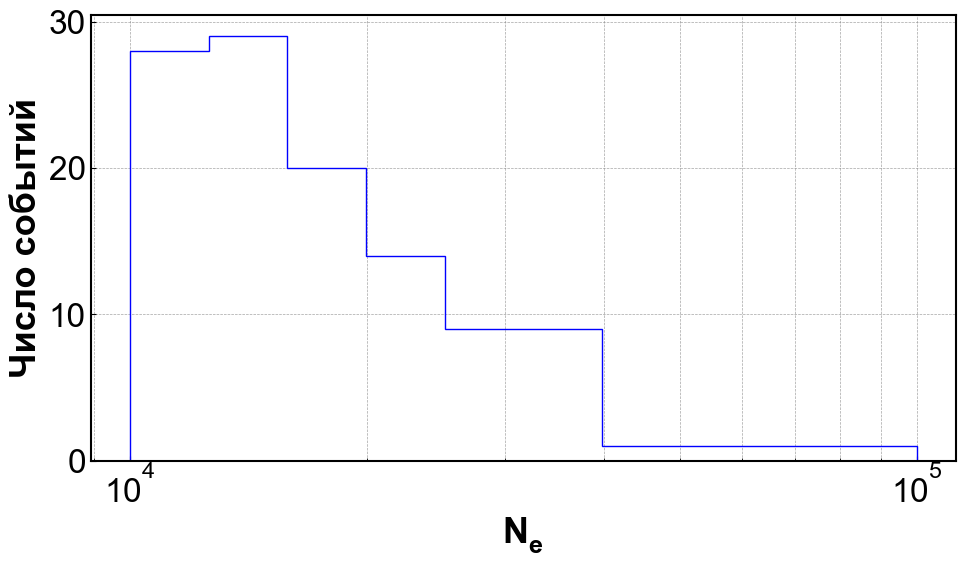

In [6]:
ne_values = f_events_df1['Ne_opt'].values

# Задаем логарифмические бин границы с шагом 0.3
log_min = np.log10(ne_values.min())
log_max = np.log10(ne_values.max())
log_bins = np.arange(log_min, log_max + 0.1, 0.1)  # шаг 0.3
bins = 10 ** log_bins  # преобразуем обратно в линейный масштаб

# Построим гистограмму
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(ne_values, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$N_e$')
plt.ylabel('Число событий')
plt.xscale('log')
plt.yscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

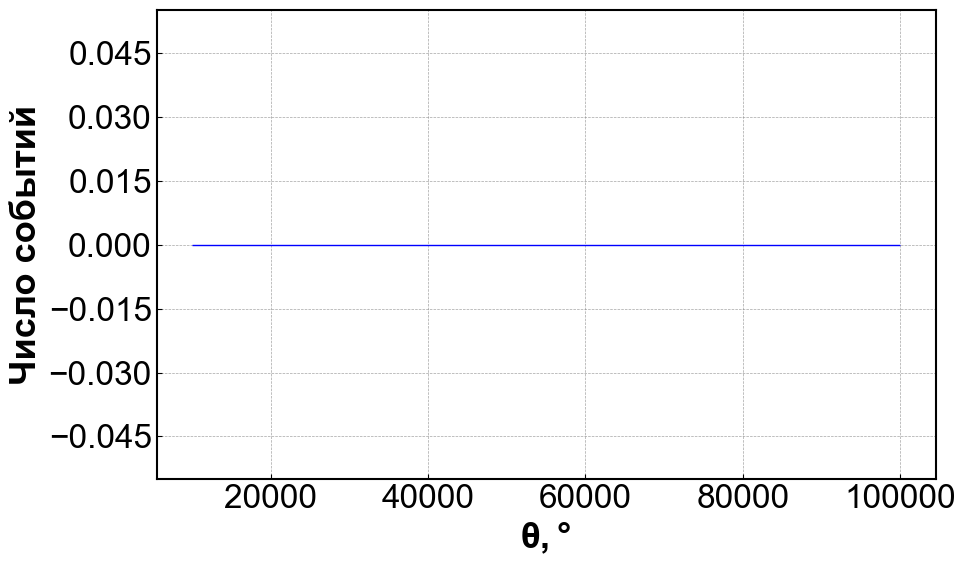

In [7]:
ne_values = f_events_df1['Theta'].values
import matplotlib.ticker as mticker
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(ne_values, bins=bins, histtype='step', color='blue')

plt.xlabel(r'$\theta, \degree$')
plt.ylabel('Число событий')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [8]:
f_events_df1.head(2)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
37,836,382082,40.02,135.32,-6.138922,24.673758,12842.777020,1.263052,0.311486,6,5,5,0,6,"[1, 2, 3, 4, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.8693000637755104, 0.14813190901360543, 0.41...","[222.336, 45.291, 125.61, 213.205, 170.027, 24...","[130.854, 22.298, 62.871, 159.539, 102.379, 15...","[2348.947, 2339.103, 2351.6, 2369.482, 2352.58..."
38,836,394725,41.86,195.02,-12.352888,2.792757,12414.746474,1.607446,0.448583,5,4,4,0,5,"[1, 2, 3, 4, 5, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.6225353422619048, 0.6518720769557823, 1.229...","[189.995, 133.803, 271.537, 155.008, 131.456, ...","[93.709, 98.125, 185.12, 82.022, 82.099, 62.04...","[2380.526, 2352.518, 2348.377, 2377.677, 2372...."


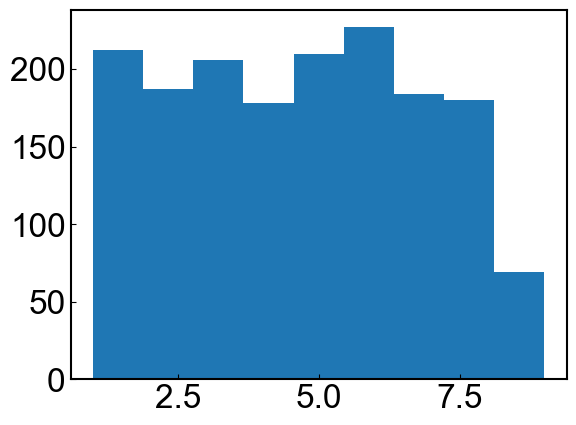

In [9]:
count = [len(cl) for cl in f_events_df['worked_clusters']]
plt.hist(count, bins=9)
plt.show()

In [10]:
Z0 = 0

row = f_events_df1.iloc[3]
nevent = row['NEvent']
nview = row['Nview']
theta = row['Theta'] 
phi = row['Phi']
rho = row['rho']
Ne = row['Ne_opt']
s = row['s_opt']


station_flags = row['station_flags']
worked_station_indices = [i for i, flag in enumerate(station_flags) if flag]

worked_coords = coordinates_df.iloc[worked_station_indices]

r = []
for _, station in worked_coords.iterrows():
    r.append(compute_r(
        float(row['X0_opt']), float(row['Y0_opt']), float(Z0),
        float(theta), float(phi),
        float(station['X']), float(station['Y']), float(station['Z'])
    )
    )

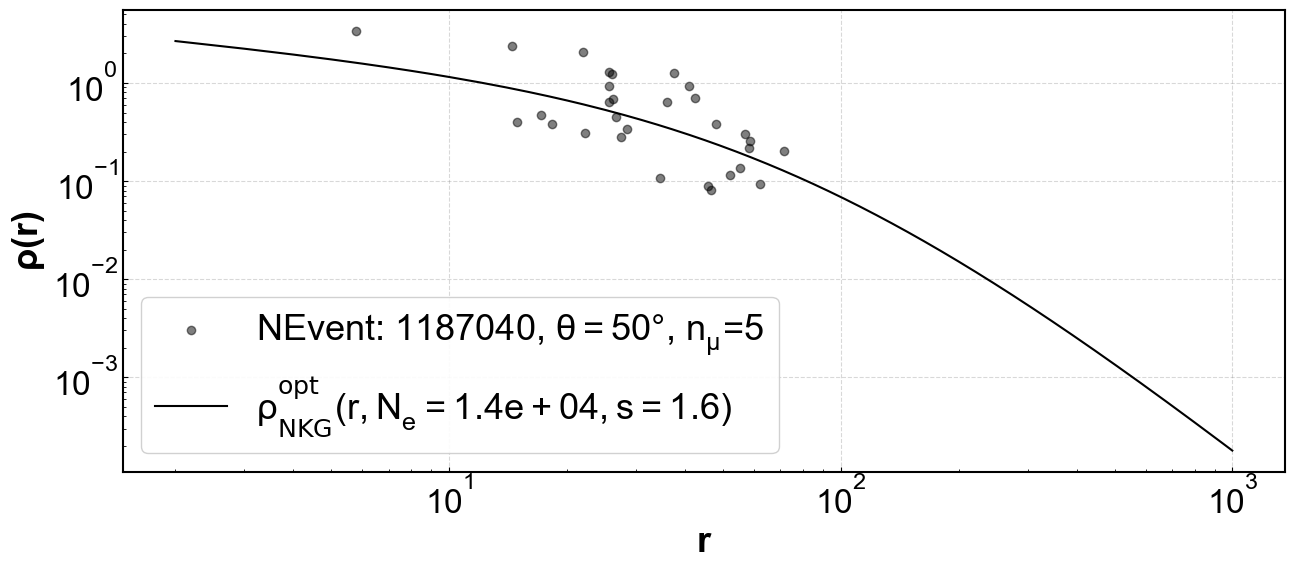

In [11]:
r_enterval= np.arange(2, 1e3, 1)
rho_calculate = rho_model(r_enterval, Ne, s)


plt.figure(figsize=(15, 6))
plt.scatter(r, rho, alpha=0.5, color='black', label=rf'NEvent: {nevent}, $\theta =${theta:.0f}$\degree$, $n_{{\mu}}$={nview}')

plt.plot(r_enterval, rho_calculate, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne:.1e}, s={s:.1f})$')


plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
# plt.savefig(f'plots/{163010}/event_{j_event}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

In [13]:
Z0 = 0
all_rs, all_rs2= [], []
all_rhos, all_rhos2 = [], []
all_s, all_s2 = [], []
all_Ne, all_Ne2 = [], []

for _, row in f_events_df1.iterrows():
    theta, phi = row['Theta'], row['Phi']
    station_flags = row['station_flags']
    worked_idx = [i for i, f in enumerate(station_flags) if f]
    coords = coordinates_df.iloc[worked_idx]
    rho_vals = row['rho']
    rs = [
        compute_r(
            row['X0_opt'], row['Y0_opt'], Z0,
            theta, phi,
            float(stat['X']), float(stat['Y']), float(stat['Z'])
        )
        for _, stat in coords.iterrows()
    ]
    if len(rs) != len(rho_vals):
        continue
    all_rs.extend(rs)
    all_rhos.extend(rho_vals)
    all_s.extend([row['s_opt'] ] * len(rs))
    all_Ne.extend([row['Ne_opt']]* len(rs))
    
Ne_low = 1e4
Ne_hight = 1e5
s_val = 1.5
rho_calculate_low = rho_model(r_enterval, Ne=Ne_low, s=s_val)
rho_calculate_hight = rho_model(r_enterval, Ne=Ne_hight, s=s_val)

In [14]:
Z0 = 0
all_rs_e3, all_rs2_e3 = [], []
all_rhos_e3, all_rhos2_e3 = [], []
all_s_e3, all_s2_e3 = [], []
all_Ne_e3, all_Ne2_e3 = [], []

for _, row in f_events_df2.iterrows():
    theta, phi = row['Theta'], row['Phi']
    station_flags = row['station_flags']
    worked_idx = [i for i, f in enumerate(station_flags) if f]
    coords = coordinates_df.iloc[worked_idx]
    rho_vals = row['rho']
    rs = [
        compute_r(
            row['X0_opt'], row['Y0_opt'], Z0,
            theta, phi,
            float(stat['X']), float(stat['Y']), float(stat['Z'])
        )
        for _, stat in coords.iterrows()
    ]
    if len(rs) != len(rho_vals):
        continue
    all_rs_e3.extend(rs)
    all_rhos_e3.extend(rho_vals)
    all_s_e3.extend([row['s_opt'] ] * len(rs))
    all_Ne_e3.extend([row['Ne_opt']]* len(rs))

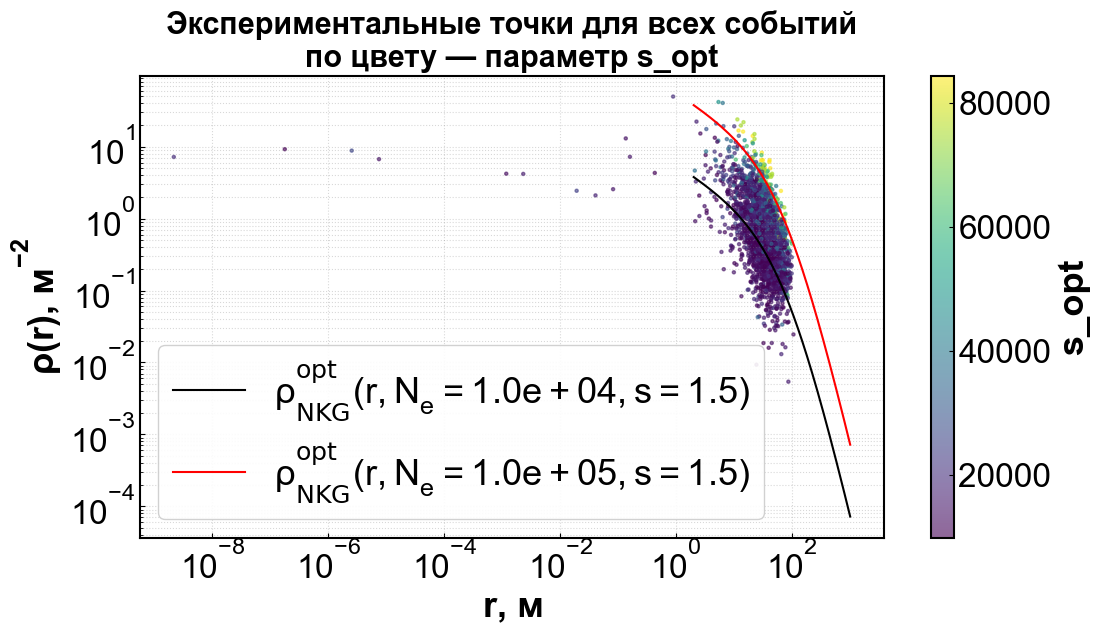

In [15]:
plt.figure(figsize=(12,6))

plt.plot(r_enterval, rho_calculate_low, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_low:.1e}, s={s_val:.1f})$')
plt.plot(r_enterval, rho_calculate_hight, c='red', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

sc = plt.scatter(all_rs, all_rhos, c=all_Ne, cmap='viridis', s=5, alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.colorbar(sc, label='s_opt')
plt.xlabel(r'$r$, м'); plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.title('Экспериментальные точки для всех событий\nпо цвету — параметр s_opt')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

In [16]:
r_kascade1 = kascade1_df['r']
r_kascade2 = kascade2_df['r']
r_kascade3 = kascade3_df['r']


rho_kascade1 = kascade1_df['rho']
rho_kascade2 = kascade2_df['rho']
rho_kascade3 = kascade3_df['rho']


In [17]:
r_bin_events_e4, rho_mean_events_e4,  yer_events_e4, rho_median_events_e4 = binned_log_stats(all_rs, all_rhos, num_bins=30, r_min_val=10, r_max_val=1000)

In [18]:
r_bin_events_e3, rho_mean_events_e3,  yer_events_e3, rho_median_events_e3 = binned_log_stats(all_rs_e3, all_rhos_e3, num_bins=20, r_min_val=10, r_max_val=500)

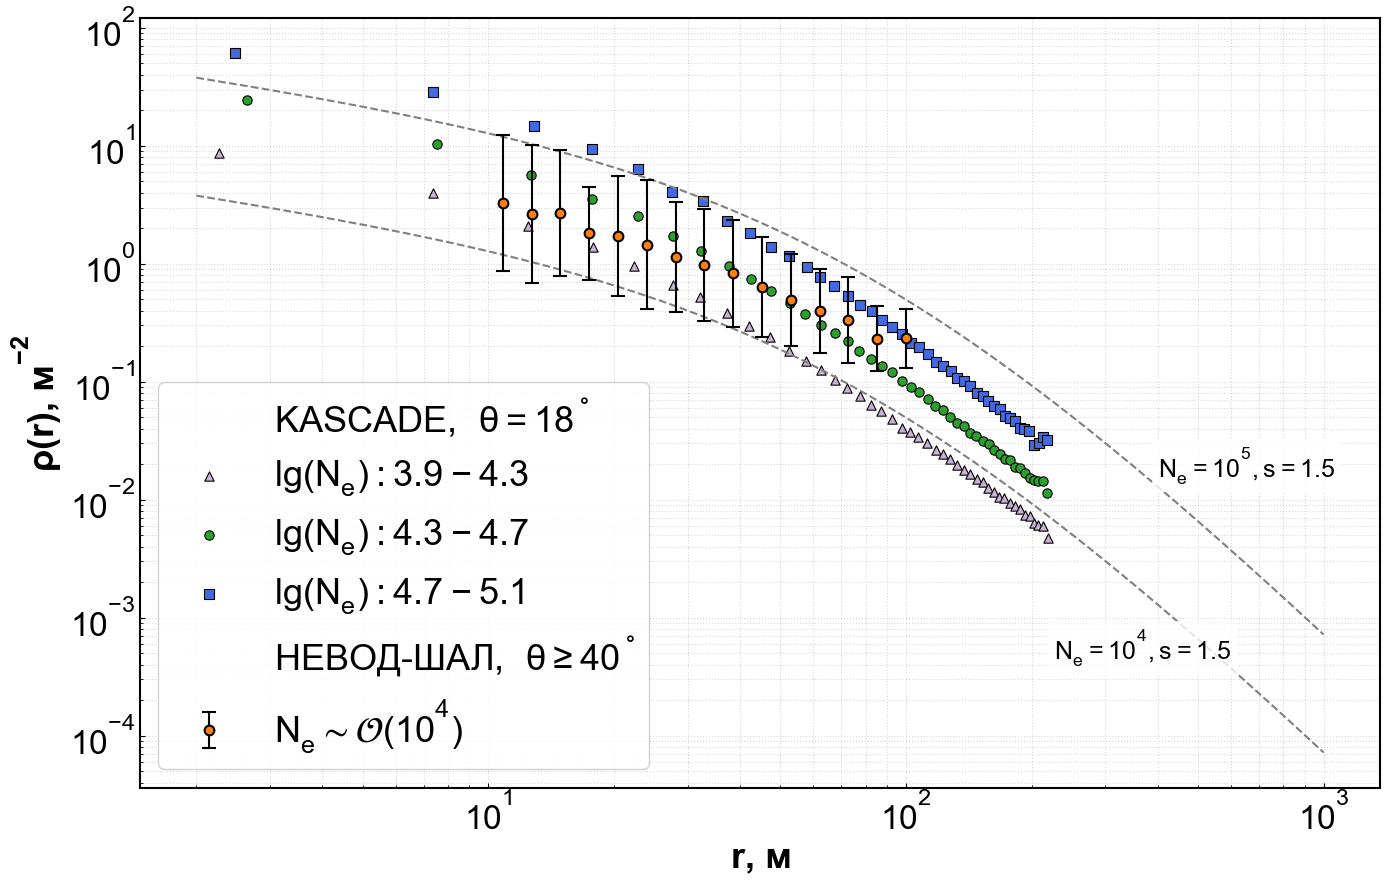

In [19]:
plt.figure(figsize=(16, 10))


line1, = plt.plot(r_enterval, rho_calculate_low, c='gray', linestyle='--')
line2, = plt.plot(r_enterval, rho_calculate_hight, c='gray', linestyle='--')

def add_label(line, text, x_pos=0.5, pos='right', fontsize=18, color=None):
    y_pos = np.interp(x_pos, r_enterval, line.get_ydata())
    text_color = color if color is not None else line.get_color()
    plt.text(x_pos, y_pos, text, 
             color=text_color,
             ha=pos, va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontsize=fontsize)

add_label(line1, fr'$N_e=10^{{{int(np.log10(Ne_low))}}},s=1.5$', x_pos=600, pos='right', fontsize=18, color='black')
add_label(line2, fr'$N_e=10^{{{int(np.log10(Ne_hight))}}},s=1.5$', x_pos=400, pos='left', fontsize=18, color='black')

plt.scatter(r_kascade3, rho_kascade3,  edgecolor='black', 
           linewidths=0.8, color='#cab2d6', alpha=1, s=45, marker='^', label=r'$lg(N_e):3.9-4.3$')
plt.scatter(r_kascade1, rho_kascade1, edgecolor='black', 
           linewidths=0.8, color='#2ca02c', alpha=1, s=45, label=r'$lg(N_e):4.3-4.7$')
plt.scatter(r_kascade2, rho_kascade2,  edgecolor='black', 
           linewidths=0.8, color='royalblue', alpha=1, s=45, marker='s', label=r'$lg(N_e):4.7-5.1$')

plt.errorbar(r_bin_events_e4,rho_mean_events_e4, yerr= yer_events_e4,
             color='#ff7f0e', fmt='o', capsize=5, markersize=7,
             markeredgecolor='black', markeredgewidth=1.5,
             ecolor='black',
             label=r'$N_e \sim \mathcal{O} (10^4)$')

fake_line_KASCADE = Line2D([0], [0], color='none', label=r'KASCADE, $\ \theta =  18^\circ$')
fake_line_NEAS = Line2D([0], [0], color='none', label=r'НЕВОД-ШАЛ, $\ \theta \geq 40^\circ$')


handles, labels = plt.gca().get_legend_handles_labels()

handles.insert(0, fake_line_KASCADE)
labels.insert(0, fake_line_KASCADE.get_label())

handles.insert(-1, fake_line_NEAS)
labels.insert(-1, fake_line_NEAS.get_label())

plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.legend(handles=handles, labels=labels, loc='best')
plt.show()


## CORSIKA + GEANT

In [57]:
geant_data_dir = 'geant_data'
wich_data = 'spe'
filter_geant_2_file = 'spe27_theta_ge_40.parquet'
filter_geant_1_file = 'spe27p1416_theta_ge_40.parquet'
filter_geant_2_filepath  = os.path.join(geant_data_dir,wich_data, filter_geant_2_file)
filter_geant_1_filepath = os.path.join(geant_data_dir,wich_data, filter_geant_1_file)

In [58]:
geant2_df = pd.read_parquet(filter_geant_2_filepath)
geant1_df = pd.read_parquet(filter_geant_1_filepath)

geant2_ne_e4_df = geant2_df[
    (geant2_df['NeNKGlong'] < 4e4) & (geant2_df['NeNKGlong'] > 1e4)
]

r_rho_pairs = [
    (r, rho)
    for r_list, rho_list in zip(geant2_ne_e4_df["r_vals"], geant2_ne_e4_df["rho_vals"])
    if isinstance(r_list, (list, np.ndarray)) and isinstance(rho_list, (list, np.ndarray))
    for r, rho in zip(r_list, rho_list)
]

r_geant2, rho_geant2 = map(np.array, zip(*r_rho_pairs))
mask = r_geant2 >= 2
r_geant2 = r_geant2[mask]
rho_geant2 = rho_geant2[mask]

In [78]:
geant2_ne_e4_df = geant2_df[
    (geant2_df['NeNKGlong'] < 4e4) & (geant2_df['NeNKGlong'] > 1e4)
]

geant2_ne_e3_df = geant1_df[
    (geant2_df['NeNKGlong'] < 1e4) & (geant2_df['NeNKGlong'] > 1e3)
]


r_rho_pairs = [
    (r, rho)
    for r_list, rho_list in zip(geant2_ne_e4_df["r_vals"], geant2_ne_e4_df["rho_vals"])
    if isinstance(r_list, (list, np.ndarray)) and isinstance(rho_list, (list, np.ndarray))
    for r, rho in zip(r_list, rho_list)
]

r_geant2, rho_geant2 = map(np.array, zip(*r_rho_pairs))
mask = r_geant2 >= 2
r_geant2 = r_geant2[mask]
rho_geant2 = rho_geant2[mask]

r_rho_pairs_e3 = [
    (r, rho)
    for r_list, rho_list in zip(geant2_ne_e3_df["r_vals"], geant2_ne_e3_df["rho_vals"])
    if isinstance(r_list, (list, np.ndarray)) and isinstance(rho_list, (list, np.ndarray))
    for r, rho in zip(r_list, rho_list)
]

r_geant2_e3, rho_geant2_e3 = map(np.array, zip(*r_rho_pairs_e3))
mask = r_geant2_e3 >= 2
r_geant2_e3 = r_geant2_e3[mask]
rho_geant2_e3 = rho_geant2_e3[mask]

C:\Users\matsvei\AppData\Local\Temp\ipykernel_6668\2340373529.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geant2_ne_e3_df = geant1_df[


In [79]:
theta_arr = np.array(np.array(geant1_df['Teta']))
Ne_arr = np.array(np.array(geant1_df['NeNKGlong']))

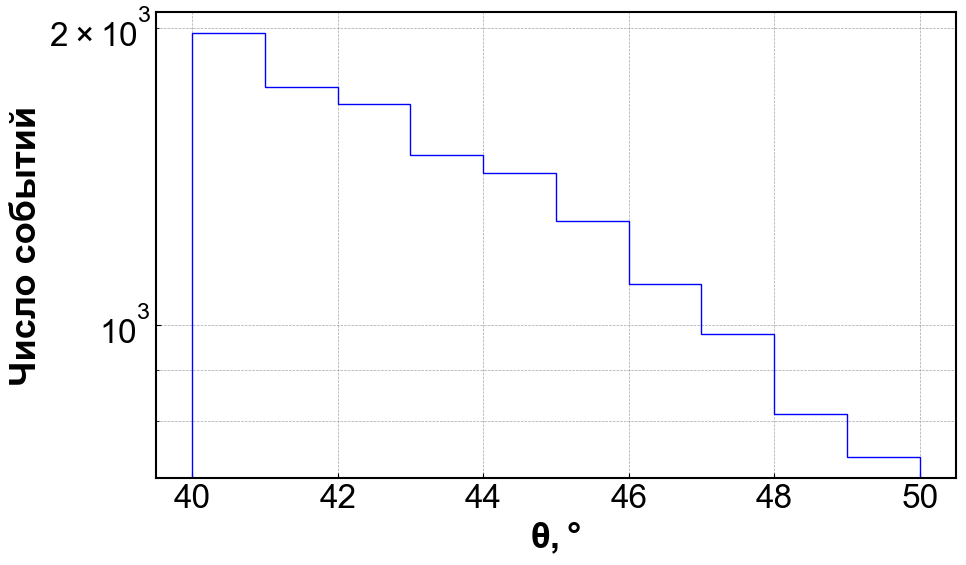

In [80]:

bins = 10
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(theta_arr, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$\theta,\degree$')
plt.ylabel('Число событий')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

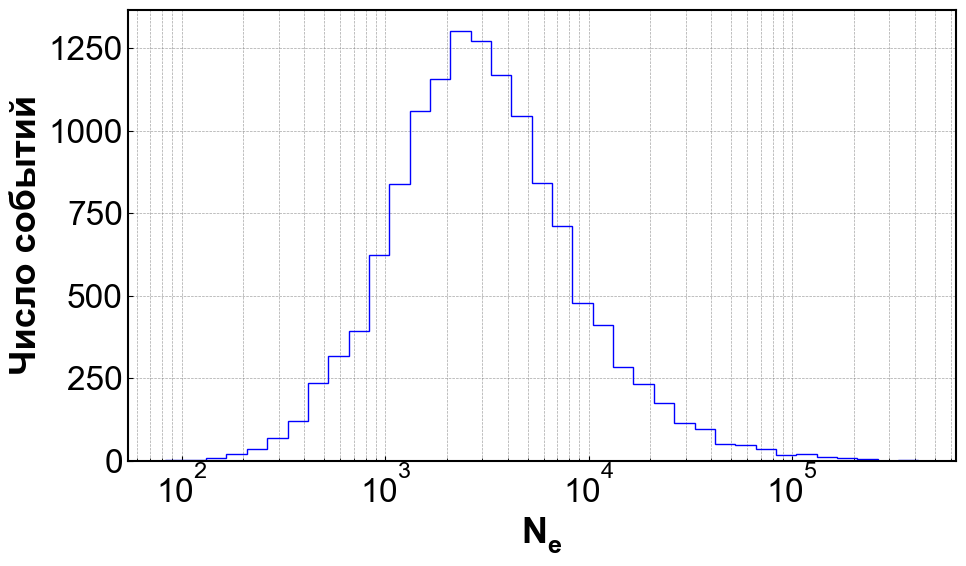

In [81]:
log_min = np.log10(Ne_arr.min())
log_max = np.log10(Ne_arr.max())
log_bins = np.arange(log_min, log_max + 0.1, 0.1) 
bins = 10 ** log_bins  

plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(Ne_arr, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$N_e$')
plt.ylabel('Число событий')
plt.xscale('log')
plt.yscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [84]:
r_bin_geant2_e4, rho_mean_geant2_e4,  yer_geant4_e4, rho_median_geant4_e4 = binned_log_stats(
    r_geant2, rho_geant2, 
    num_bins=30, 
    r_min_val=1, 
    r_max_val=1000
)

r_bin_geant2_e3, rho_mean_geant2_e3,  yer_geant4_e3, rho_median_geant4_e3 = binned_log_stats(
    r_geant2_e3, rho_geant2_e3, 
    num_bins=20, 
    r_min_val=1, 
    r_max_val=1000
)

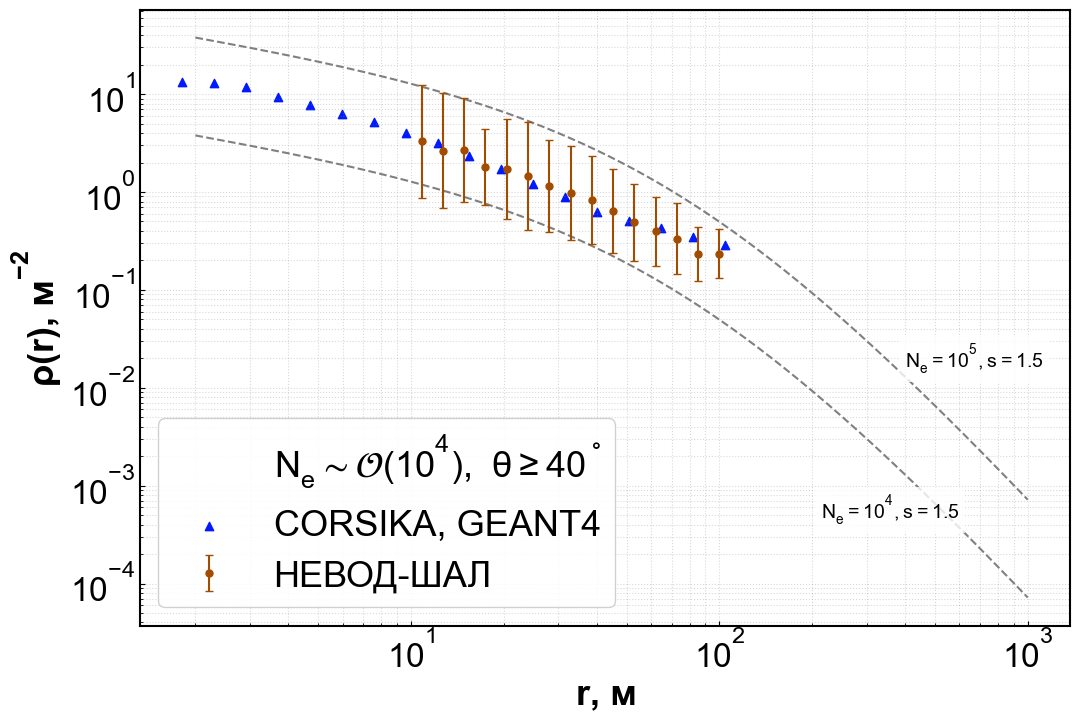

In [86]:
plt.figure(figsize=(12, 8))
# plt.plot(r_enterval, rho_calculate, c='black', 
#          label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

line1, = plt.plot(r_enterval, rho_calculate_low, c='gray', linestyle='--')
line2, = plt.plot(r_enterval, rho_calculate_hight, c='gray', linestyle='--')

def add_label(line, text, x_pos=0.5, pos='right', fontsize=14, color=None):
    y_pos = np.interp(x_pos, r_enterval, line.get_ydata())
    text_color = color if color is not None else line.get_color()
    plt.text(x_pos, y_pos, text, 
             color=text_color,
             ha=pos, va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontsize=fontsize)

add_label(line1, fr'$N_e=10^{{{int(np.log10(Ne_low))}}},s=1.5$', x_pos=600, pos='right', color='black')
add_label(line2, fr'$N_e=10^{{{int(np.log10(Ne_hight))}}},s=1.5$', x_pos=400, pos='left', color='black')


plt.errorbar(r_bin_events_e4 ,rho_mean_events_e4, yerr= yer_events_e4,
             color="#a34c00", fmt='o', capsize=3, markersize=5,
             label=r'НЕВОД-ШАЛ')

# plt.errorbar(r_bin_events_e3 ,rho_median_events_e3 * 0.7, yerr= [yer/2 for yer in yer_events_e3],
#              color="#a30000", fmt='o', capsize=3, markersize=5,
#              label=r'НЕВОД-ШАЛ')


# plt.errorbar(
#     r_bin_centers[valid_bins][:-1], 
#     mean_rho_in_bins[valid_bins][:-1], 
#     yerr=[
#         yerr_lower_vals[:-1], 
#         yerr_upper_vals[:-1]
#     ],
#     fmt='^', capsize=3, markersize=5, 
#     color="#001aff", label='смоде'
# )

# plt.errorbar(
#     r_bin_geant2_e4[:-1], 
#     rho_median_geant4_e4[:-1], 
#     yerr=[yer_geant4_e4[0][:-1],yer_geant4_e4[1][:-1]],
#     fmt='^', capsize=3, markersize=5, 
#     color="#001aff", label='смоде'
# )

plt.scatter(
    r_bin_geant2_e4[:-1], 
    rho_median_geant4_e4[:-1], 
    marker='^',
    color="#001aff", label='CORSIKA, GEANT4'
)

# plt.scatter(
#     r_bin_geant2_e3[:-1], 
#     rho_mean_geant2_e3[:-1], 
#     marker='^',
#     color="#00ff04", label='CORSIKA, GEANT4'
# )




fake_line = Line2D([0], [0], color='none', label=r'$N_e \sim \mathcal{O} (10^4),\ \theta \geq 40^\circ$')

handles, labels = plt.gca().get_legend_handles_labels()

handles = [fake_line] + handles
labels = [fake_line.get_label()] + labels


plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.legend(handles=handles, labels=labels, loc='best')
plt.show()